# Investigation on neural networks

In this notebook we explore several properties of neural networks and the influence of some parameters on the overall performance.
You are not allowed to import any other library than the ones already imported. We only ask you to add some lines of code, removing or changing the given code is not allowed.

### Learning parameters

In [1]:
N_EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 0.001
N_SAMPLES = 500
USE_CONVOLUTIONS = True
RELU_AS_ACTIVATION = False

### Load the dataset

#### Question 1: fill the "TO DO" lines to load the given dataset

In [2]:
import jax.numpy as jnp

train_images = jnp.load("train_images.npy")[:N_SAMPLES]
train_labels = jnp.load("train_labels.npy")[:N_SAMPLES]
test_images = jnp.load("test_images.npy")
test_labels = jnp.load("test_labels.npy")
n_samples = train_images.shape[0]

if USE_CONVOLUTIONS:
    train_images = train_images.reshape((-1, 28, 28))
    test_images = test_images.reshape((-1, 28, 28))
print(train_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


### Plots of some samples

#### Question 2: plot the 9 first samples of the train dataset on a 3 x 3 grid. The title of each subplot is the label of the image shown in the subplot.

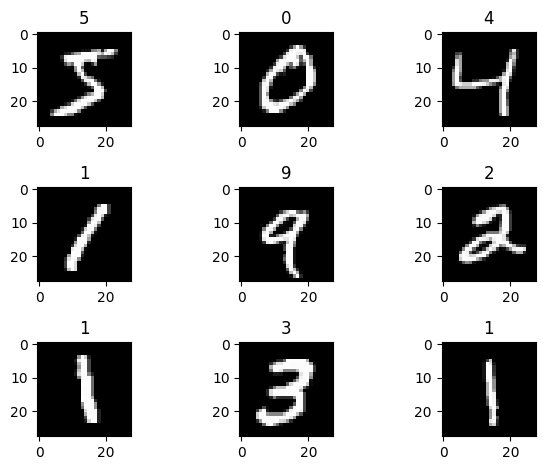

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3)

for i in range(3):
    for j in range(3):
        axes[i,j].imshow(train_images[3*i+j].reshape((28,28,1)), cmap='gray')
        axes[i,j].set_title(jnp.nonzero(train_labels[3*i+j])[0][0])

plt.tight_layout()

### Neural network implementation

#### Question 3: Implement a Multi-Layer Perceptron (MLP) with the following architecture: Linear 512 - * - Linear 512 - * - Linear 512 - * - Linear 10, where * is ReLU if relu_as_activation is True and Tanh otherwise.

In [4]:
import flax.linen as nn

class MLP(nn.Module):
    """A simple MLP model."""
    relu_as_activation: bool

    @nn.compact
    def __call__(self, x):
        # make sure x is a batch
        x = jnp.atleast_2d(x)
        for i in range(3):
            x = nn.Dense(features=512)(x)
        x = nn.relu(x) if self.relu_as_activation else nn.tanh(x)
        x = nn.Dense(features=10)(x)
        return x

#### Question 4: Implement a Convolutional Neural Network (CNN) with the following architecture: Conv 32 - * - AvgPool - Conv 64 - * - AvgPool - Linear 256 - * - Linear 10, where * is ReLU if relu_as_activation is True and Tanh otherwise and AvgPool is an average pooling layer. The kernel size for the convolutional layers is 3 x 3, the rest of the parameters are left unchanged from the default implementation of flax. The window size of the average pooling layers is 2 x 2 and the stride is 2 x 2, the rest of the parameters are left unchanged from the default implementation of flax.

In [5]:
class CNN(nn.Module):
    """A simple CNN model."""
    relu_as_activation: bool

    @nn.compact
    def __call__(self, x):
        # make sure x is a batch
        x = jnp.atleast_3d(x)
        # nn.Conv uses channel last convention
        x = x[:,:,:, jnp.newaxis]
        conv_features = [32,64]
        for feat in conv_features:
            x = nn.Conv(features=feat, kernel_size=(3,3))(x)
            x = nn.relu(x) if self.relu_as_activation else nn.tanh(x)
            x = nn.avg_pool(x, window_shape=(2,2), strides=(2,2))
        x = x.reshape((x.shape[0],-1))
        x = nn.Dense(features=256)(x)
        x = nn.relu(x) if self.relu_as_activation else nn.tanh(x)
        x = nn.Dense(features=10)(x)
        return x

#### Question 5: Implement the model that we will train in the following cells.

In [6]:
from functools import partial
import jax
import optax


class Model:
    def __init__(self, network, key, learning_rate, batch_size) -> None:
        self.network = network
        if type(self.network) == CNN:
            self.params = self.network.init(key, x=train_images[:batch_size])
        else:
            self.params = self.network.init(key, x=train_images[:batch_size])
        self.optimizer = optax.adam(learning_rate)
        self.optimizer_state = self.optimizer.init(self.params)

    #@partial(jax.jit, static_argnames="self")
    def loss(self, params, batch) -> float:
        """
        Compute the softmax cross entropy and average it over the batch given as input.
        """
        X, Y = batch
        fX = self.network.apply(params, X)
        return optax.softmax_cross_entropy(fX, Y).mean()


    #@partial(jax.jit, static_argnames="self")
    def update_model(self, params, batch, optimizer_state):
        """
        Performs one gradient step on the batch given as input.
        """
        loss, grad_loss = jax.value_and_grad(self.loss)(params, batch)
        updates, optimizer_state = self.optimizer.update(grad_loss, optimizer_state)
        params = optax.apply_updates(params, updates)
        return params, optimizer_state, loss, grad_loss



    #@partial(jax.jit, static_argnames="self")
    def accuracy(self, params, batch) -> float:
        """
        Compute the accuracy of the model and average it over the batch given as input.
        """
        X, Y = batch
        fX = self.network.apply(params, X)
        return jnp.mean(jnp.argmax(fX,axis=1) == jnp.argmax(Y,axis=1))

#### Utils

In [7]:
def get_batch_indexes(key, n_samples, batch_size):
    perms = jax.random.permutation(key, n_samples)
    perms = perms[: n_samples // batch_size * batch_size]  # skip incomplete batch
    return perms.reshape((-1, batch_size))

### Training the model

#### Question 6: Write a script to train an instance of the class Model on the given dataset.

In [8]:
import time
from tqdm.notebook import tqdm
import numpy as np


key = jax.random.PRNGKey(0)  # for deterministic randomness purposes

model = Model(CNN(RELU_AS_ACTIVATION) if USE_CONVOLUTIONS else MLP(RELU_AS_ACTIVATION), key, LEARNING_RATE, BATCH_SIZE)
training_loss = np.zeros(N_EPOCHS)
test_loss = np.zeros(N_EPOCHS)
training_accuracy = np.zeros(N_EPOCHS)
test_accuracy = np.zeros(N_EPOCHS)
grad_norm_first_layer = np.zeros(N_EPOCHS)
grad_norm_last_layer = np.zeros(N_EPOCHS)

print("\nStarting training...")
start_time = time.time()
tst = True
for epoch_idx in tqdm(range(N_EPOCHS)):
    key, _ = jax.random.split(key)
    permutations = get_batch_indexes(key, n_samples, BATCH_SIZE)

    for batch_indexes in tqdm(permutations, leave=False):
        batch = (train_images[batch_indexes], train_labels[batch_indexes])
        model.params, model.optimizer_state, loss, grad_loss = model.update_model(model.params, batch, model.optimizer_state)
        training_loss[epoch_idx] += loss
        training_accuracy[epoch_idx] += model.accuracy(model.params, batch)

        grad_loss_norm = jax.tree_map(jnp.linalg.norm, grad_loss)
        grad_norm_first_layer[epoch_idx] += grad_loss_norm["params"]["Conv_0" if USE_CONVOLUTIONS else "Dense_0"]["kernel"]
        grad_norm_last_layer[epoch_idx] += grad_loss_norm["params"]["Dense_1" if USE_CONVOLUTIONS else "Dense_3"]["kernel"]


    training_loss[epoch_idx] /= len(permutations)
    training_accuracy[epoch_idx] /= len(permutations)
    grad_norm_first_layer[epoch_idx] /= len(permutations)
    grad_norm_last_layer[epoch_idx] /= len(permutations)
    test_loss[epoch_idx] = model.loss(model.params, (test_images, test_labels))
    test_accuracy[epoch_idx] = model.accuracy(model.params, (test_images, test_labels))


print("Training time:", jnp.round(time.time() - start_time), "s")


Starting training...


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training time: 36.0 s


### Plots of the training and testing metrics

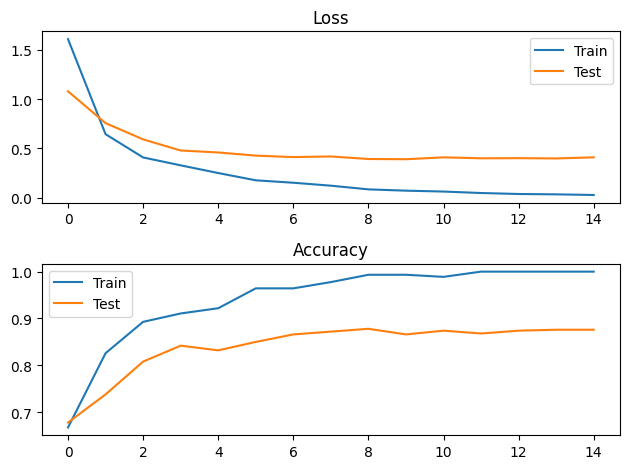

In [9]:
fig, ax = plt.subplots(2)

ax[0].plot(training_loss, label="Train")
ax[0].plot(test_loss, label="Test")
ax[0].legend()
ax[0].set_title("Loss")
ax[1].plot(training_accuracy, label="Train")
ax[1].plot(test_accuracy, label="Test")
ax[1].legend()
_ = ax[1].set_title("Accuracy")
plt.tight_layout()

### Plots of the first missclassified sample

#### Question 7: Plot the first miss-classified sample of the test dataset.

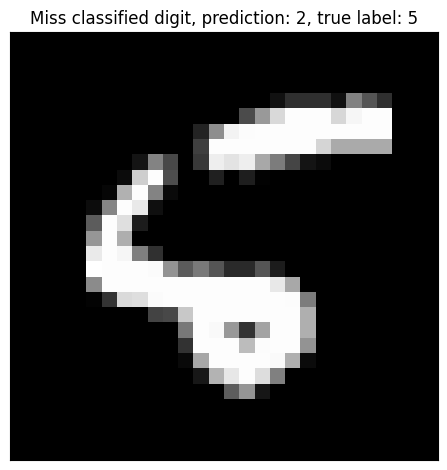

In [10]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

preds = model.network.apply(model.params, test_images)
preds = preds.argmax(axis=1)
labels = test_labels.argmax(axis=1)

idx_first_error = (preds != labels).nonzero()[0][0]
prediction_first_error = preds[idx_first_error]
label_first_error = labels[idx_first_error]

plt.imshow(test_images[idx_first_error].reshape(28, 28), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title(f"Miss classified digit, prediction: {prediction_first_error}, true label: {label_first_error}")
plt.tight_layout()

### Store gradient norms

In [11]:
network_type = "cnn" if USE_CONVOLUTIONS else "mlp"
activation_type = "_relu" if RELU_AS_ACTIVATION else "_tanh"

np.save("grad_norm_first_layer_" + network_type + activation_type, grad_norm_first_layer)
np.save("grad_norm_last_layer_" + network_type + activation_type, grad_norm_last_layer)

### Plot gradient norms

In [12]:
RUN_BOTH_ACTIVATIONS = False

if RUN_BOTH_ACTIVATIONS:
    grad_norm_first_layer_relu = jnp.load(f"grad_norm_first_layer_{network_type}_relu.npy")
    grad_norm_last_layer_relu = jnp.load(f"grad_norm_last_layer_{network_type}_relu.npy")
    grad_norm_first_layer_tanh = jnp.load(f"grad_norm_first_layer_{network_type}_tanh.npy")
    grad_norm_last_layer_tanh = jnp.load(f"grad_norm_last_layer_{network_type}_tanh.npy")


    plt.plot(grad_norm_first_layer_relu, label="First layer ReLU")
    plt.plot(grad_norm_last_layer_relu, label="Last layer ReLU")
    plt.plot(grad_norm_first_layer_tanh, label="First layer tanh")
    plt.plot(grad_norm_last_layer_tanh, label="Last layer tanh")

    plt.legend()
    plt.title(f"Gradients norm of the {network_type}")
    plt.tight_layout()